## Using Natural Language Processing to map gender bias in news articles about terrorism

### University of Amsterdam
#### MA Thesis New Media and Digital Culture 
##### Doortje Nipius


*The original dataset is property of the Simon Fraser University and is protected, handled and used according to the signed agreement.*

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import graphviz 

from textblob import TextBlob
import text2emotion as te
from nrclex import NRCLex

import ast

In [4]:
#Load dataframe
df = pd.read_csv('terrorism_complete.csv')

#### Data preparation

Stopwords is a list of words that are quite common but do not add much meaning to a sentence. It is integrated in NLTK and you can manually add words to the list.

In [5]:
stop = stopwords.words('english')
newStopWords = ['—','said', 'say' ]
stop.extend(newStopWords)

In [6]:
#Make a dataset with articles where there are more male sources than female. 
male = df.query('sourcesMaleCount > sourcesFemaleCount')

In [7]:
#Remove all the stopwords in the (preprocessed) body of the text 
male['body_stop'] = male['body_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#Make a dataset with articles where there are more female sources than male. 
female = df.query('sourcesFemaleCount > sourcesMaleCount')

In [9]:
#Remove all the stopwords in the (preprocessed) body of the text 
female['body_stop'] = female['body_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Sentiment analyse

The function Porterstemmer() normalises the words in the text by stemming the words into their root forms.

In [10]:
st = PorterStemmer()
male['body_stop'] = male['body_stop'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
female['body_stop'] = female['body_stop'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
#Make one big text out of all the rows, so the most frequent words can be counted
female_text = " ".join(i for i in female.body_stop)
male_text = " ".join(i for i in male.body_stop)

In [13]:
#Most frequent words
female_words = nltk.word_tokenize(female_text)
female_fd = FreqDist(female_words)
female_fd.most_common(5)

[('group', 466), ('peopl', 464), ('us', 439), ('govern', 410), ('canada', 402)]

In [14]:
#Most frequent words
male_words = nltk.word_tokenize(male_text)
male_fd = FreqDist(male_words)
male_fd.most_common(5)

[('us', 4892),
 ('attack', 3519),
 ('govern', 3390),
 ('group', 3321),
 ('peopl', 3000)]

In [15]:
#The sentiment analysis
analyzer = SentimentIntensityAnalyzer()

In [16]:
#Add's the column 'polarity' and fills it with the polarity score of the corresponding article. 
male['polarity'] = male['body_stop'].apply(lambda x: analyzer.polarity_scores(x))
female['polarity'] = female['body_stop'].apply(lambda x: analyzer.polarity_scores(x))

C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\doort\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
#Make's a column for each value in the polarity scores. 
male = pd.concat(
    [male.drop(['body'], axis=1), 
     male['polarity'].apply(pd.Series)], axis=1)

In [18]:
female = pd.concat(
    [female.drop(['body'], axis=1), 
    female['polarity'].apply(pd.Series)], axis=1)

Add's the column 'sentiment' and fill the rows according to the compound score. If it's higher than 0 it will be 'positive', equal to 0 is 'neutral' and less than zero will be 'negative'.

In [19]:
male['sentiment'] = male['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
female['sentiment'] = female['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

In [20]:
#Count both the amount of positive and negative values in the columns
male.sentiment.value_counts()

negative    1197
positive     125
Name: sentiment, dtype: int64

about 10% is positive. 

In [21]:
female.sentiment.value_counts()

negative    160
positive     26
Name: sentiment, dtype: int64

about 16% is positive.

#### Emotion analysis

**text2emotion**

In [22]:
male_string = ' '.join(male['body_stop'].tolist())

In [23]:
te.get_emotion(male_string)

{'Happy': 0.07, 'Angry': 0.05, 'Surprise': 0.22, 'Sad': 0.2, 'Fear': 0.45}

In [24]:
female_string = ' '.join(female['body_stop'].tolist())

In [25]:
te.get_emotion(female_string)

{'Happy': 0.09, 'Angry': 0.05, 'Surprise': 0.22, 'Sad': 0.2, 'Fear': 0.45}

**NRCLex**

In [26]:
#Apply NRCLex to the female 'body_stop' column
text_female = NRCLex(female_string)

In [27]:
#Calculate the frequencies of the emotions
data_female = text_female.affect_frequencies

In [28]:
#Make a small dataset with all the emotions and their scores, so it can be visualised. 
emotion_df_female = pd.DataFrame.from_dict(data_female, orient='index')
emotion_df_female = emotion_df_female.reset_index()
emotion_df_female = emotion_df_female.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df_female = emotion_df_female.sort_values(by=['Emotion Count'], ascending=False)

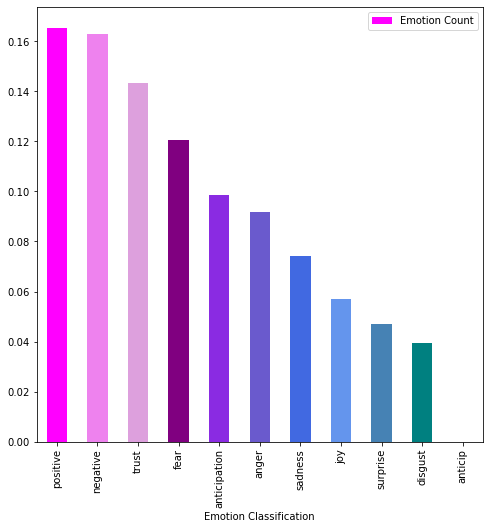

In [29]:
#Visualisation of the female texts
emotion_df_female.plot.bar(x='Emotion Classification', y= 'Emotion Count', color = ['Magenta', 'violet', 'plum' ,'purple', 'blueviolet', 'slateblue', 'royalblue',  'cornflowerblue', 'steelblue', 'teal'], figsize= (8,8))

In [30]:
#Apply NRCLex to the female 'body_stop' column
text_male = NRCLex(male_string)

In [31]:
#Calculate the frequencies of the emotions
data_male = text_male.affect_frequencies

In [32]:
#Make a small dataset with all the emotions and their scores, so it can be visualised. 
emotion_df_male = pd.DataFrame.from_dict(data_male, orient='index')
emotion_df_male = emotion_df_male.reset_index()
emotion_df_male = emotion_df_male.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df_male = emotion_df_male.sort_values(by=['Emotion Count'], ascending=False)

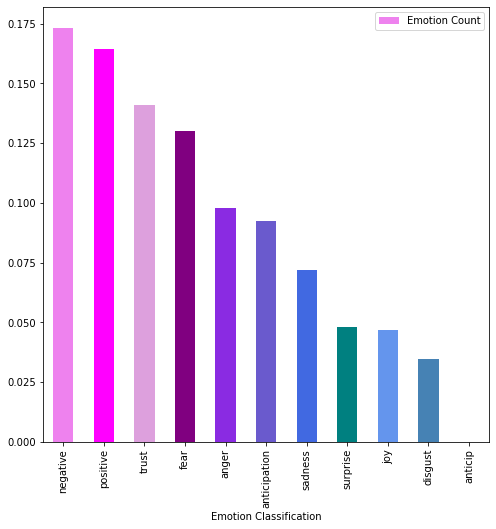

In [33]:
#Visualisation of the female texts
emotion_df_male.plot.bar(x='Emotion Classification', y= 'Emotion Count', color = [ 'violet', 'Magenta', 'plum' ,'purple', 'blueviolet', 'slateblue', 'royalblue',  'teal', 'cornflowerblue', 'steelblue', ], figsize= (8,8))

In [34]:
#Make one dataframe from both the male and female emotion frequencies.
clean_df_female = emotion_df_female.drop('Emotion Classification', axis=1)
df_M_F = pd.concat([clean_df_female, emotion_df_male], axis=1)

In [35]:
#rename the columns
df_M_F.columns = ['Emotion female articles', 'class', 'Emotion male articles']

In [36]:
#Only show the emotions with a bigger frequency than 0.
df_plot = df_M_F[df_M_F['Emotion female articles'] >0]

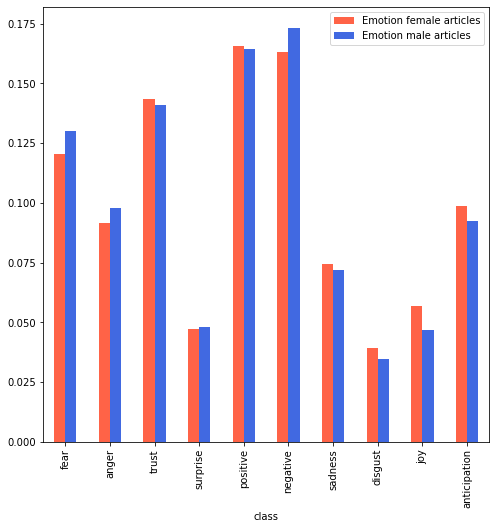

In [37]:
#Visualise both the male and female articles and their emotion frequencies in one plot.
df_plot.plot.bar(x='class', y= ['Emotion female articles', 'Emotion male articles'], color=['tomato', 'royalblue'], figsize= (8,8))

### Authors

In [38]:
len(df)

1958

In [39]:
#Make a dataset with articles where there are more female sources than male. 
author_f = df.query('authorsFemaleCount > authorsMaleCount')
#Number of rows
len(author_f)

468

In [40]:
#Make a dataset with articles where there are more female sources than male. 
author_m = df.query('authorsFemaleCount < authorsMaleCount')
#Number of rows
len(author_m)

877

In [41]:
#Percentage of female sources in articles with more female authors
round(author_f.sourcesFemaleCount.sum() / (author_f.sourcesFemaleCount.sum() + author_f.sourcesMaleCount.sum()) * 100,2)

24.38

In [42]:
#Percentage of female sources in articles with more male authors
round(author_m.sourcesFemaleCount.sum() / (author_m.sourcesFemaleCount.sum() + author_m.sourcesMaleCount.sum()) * 100,2)

20.77

### Visualize data

In [43]:
df.columns

Index(['Unnamed: 0', 'body', 'outlet', 'publishedAt', 'people',
       'authorsFemaleCount', 'authorsMaleCount', 'authorsUnknownCount',
       'peopleCount', 'peopleFemaleCount', 'peopleMaleCount',
       'peopleUnknownCount', 'sourcesFemale', 'sourcesFemaleCount',
       'sourcesMale', 'sourcesMaleCount', 'sourcesUnknown',
       'sourcesUnknownCount', 'voicesFemale', 'voicesMale', 'body_clean',
       'terrorism', 'terrorist'],
      dtype='object')

### Visualise male and female columns in one graph

Text(0.5, 0, '# Authors')

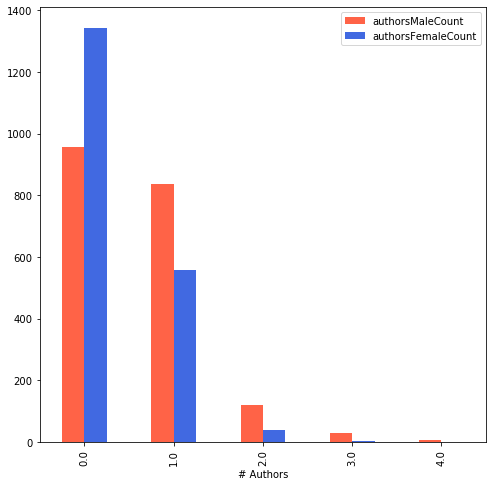

In [44]:
aut_plot = df[["authorsMaleCount", "authorsFemaleCount"]].apply(pd.Series.value_counts).plot(kind='bar', figsize=(8,8), color=['tomato', 'royalblue'])
aut_plot.set_xlabel('# Authors')

Text(0.5, 0, '# Sources')

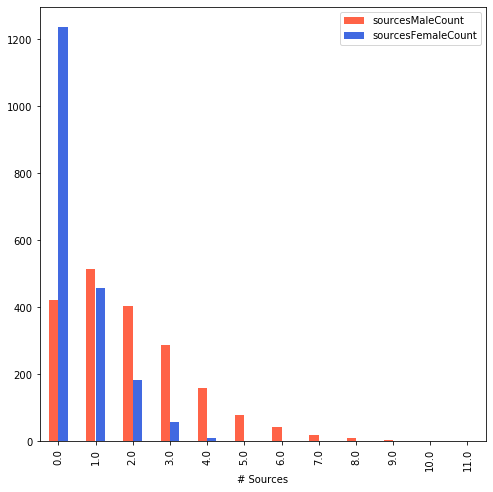

In [45]:
sourc_plot = df[["sourcesMaleCount", "sourcesFemaleCount"]].apply(pd.Series.value_counts).plot(kind='bar', figsize=(8,8), color=['tomato', 'royalblue'])
sourc_plot.set_xlabel('# Sources') 

Text(0.5, 0, '# People')

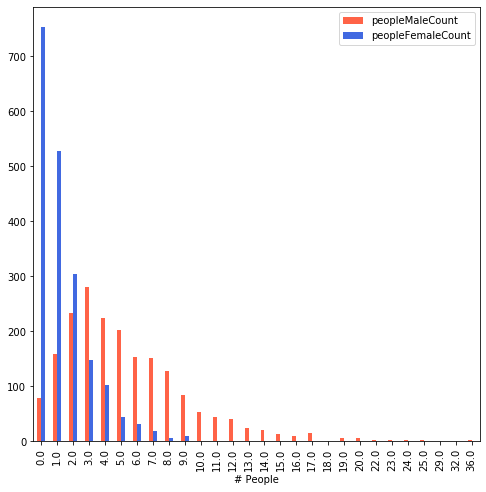

In [46]:
people_plot = df[["peopleMaleCount", "peopleFemaleCount"]].apply(pd.Series.value_counts).plot(kind='bar', figsize=(8,8), color=['tomato', 'royalblue'])
people_plot.set_xlabel('# People')

### Gender distribution per newspaper

In [47]:
df.outlet.value_counts()

The Star              725
The Globe And Mail    311
Global News           305
National Post         225
CBC News              204
CTV News              181
Huffington Post         7
Name: outlet, dtype: int64

In [48]:
#make new dataframe grouped by outlet 
df_outlet = df.groupby(['outlet']).sum()

In [49]:
#New column of the sum of 'peopleMaleCount' and 'peopleFemaleCount'
df_outlet['M_F_people'] = df_outlet.sourcesFemaleCount + df_outlet.sourcesMaleCount

In [50]:
#Percentage of women in people mentioned per newspaper
df_outlet['Female_%'] = round(df_outlet.sourcesFemaleCount / df_outlet.M_F_people * 100,2)

In [51]:
#Percentage of men in people mentioned per newspaper
df_outlet['Male_%'] = round(df_outlet.sourcesMaleCount / df_outlet.M_F_people * 100,2)

Text(0.5, 0, 'Percentage')

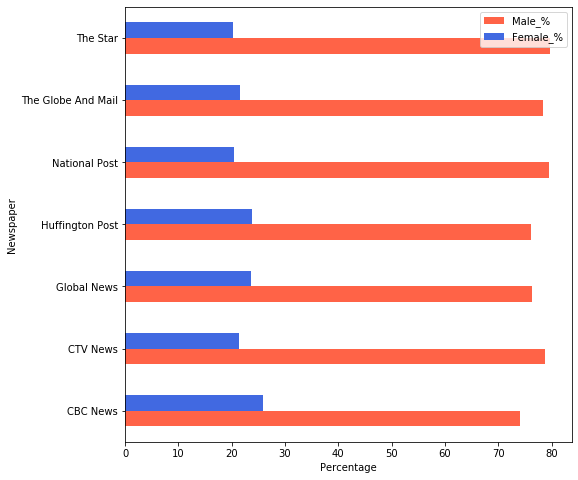

In [52]:
ax = df_outlet[["Male_%", "Female_%"]].plot(kind='barh', figsize=(8,8), color=['tomato', 'royalblue'])
ax.set_ylabel('Newspaper')
ax.set_xlabel('Percentage')

## People

The rows of column 'people' needed to be cleaned. Some lists in the rows contained floats (numbers), these are filtered out because we only need names (of type string). A new dataframe with only the filtered rows is created.

In [53]:
people_string = []
for name in df.people:
    try:
        float(name)
    except ValueError:
        people_string.append(name)

In [54]:
people_new = pd.DataFrame(people_string)
#rename column
people_new.columns = ['people']

In [55]:
people_new['people_clean'] = people_new.people.apply(lambda x: eval(str(x)))

In [56]:
x = sum(people_new.people_clean, [])

In [57]:
#unique names
len(set(x))

5399

In [58]:
#Count the names
Counter(x).most_common(12)

[('Joe Biden', 396),
 ('Donald Trump', 305),
 ('Justin Trudeau', 200),
 ('Osama bin Laden', 104),
 ('Nathaniel Veltman', 82),
 ('Bill Blair', 77),
 ('Antony Blinken', 76),
 ('Barack Obama', 73),
 ('Salman Afzaal', 69),
 ('George W Bush', 66),
 ('Jagmeet Singh', 63),
 ('Madiha Salman', 62)]

#### People wordcloud 

A wordcloud of all the people to have a quick overview of who occur the most. 

In [59]:
people_text = " ".join(review for review in people_new.people_clean.astype(str))

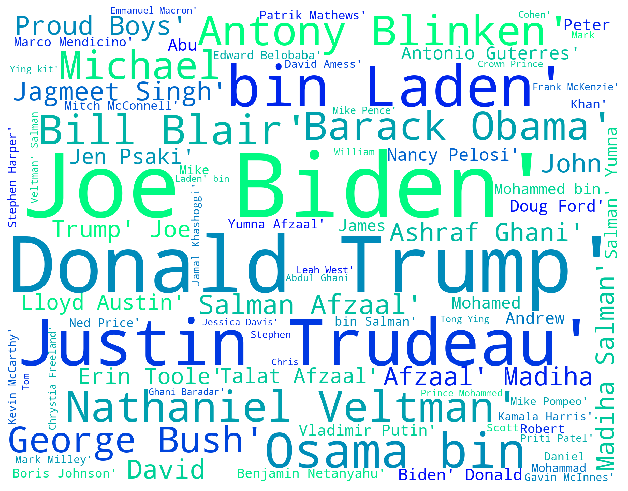

In [60]:
wordcloud = WordCloud(width=1800, height=1400, colormap='winter', background_color='white', max_words=80).generate(people_text)

plt.figure( figsize=(11,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Family

First, the male and female texts are transformed in wordclouds to examine the most occuring words. 

In [61]:
#make text for wordcloud of body female articles
female_text = " ".join(review for review in female.body_stop.astype(str))

In [62]:
#make text for wordcloud of body male articles
male_text = " ".join(review for review in male.body_stop.astype(str))

#### Wordcloud female

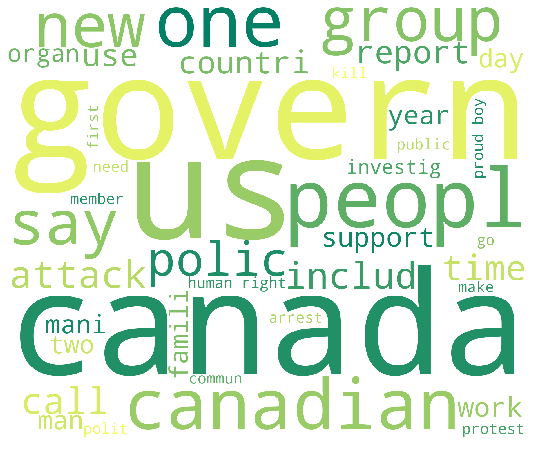

In [63]:
wordcloud = WordCloud(width=1800, height=1500, colormap='summer', background_color='white', max_words=40).generate(female_text)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud male

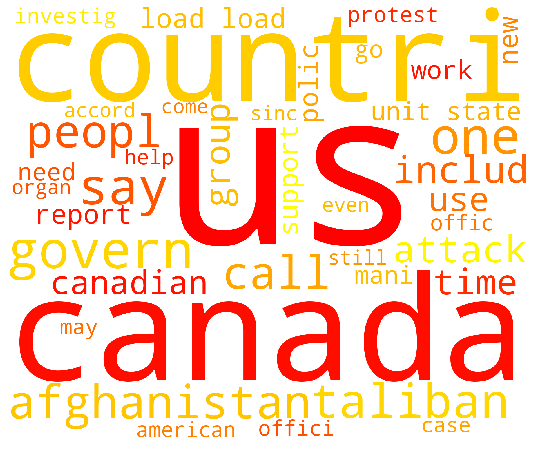

In [64]:
wordcloud = WordCloud(width=1800, height=1500, colormap='autumn', background_color='white', max_words=40).generate(male_text)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The word 'family' occured more often in the female articles than in the male ones. To take a more detailed look at these articles, a dataset is created with articles filtered on the word 'family'. Afterwards, the percentage of female sources, authors and people are calculated and compared to the percentages of the columns of the dataset containing all articles. 

In [65]:
#Filter on the word 'family'
string_list = ['family']

In [66]:
def find_match_count(word: str, pattern: str) -> int:
    return len(re.findall(pattern, word.lower()))

In [67]:
for col in string_list:
    df[col] = df['body_clean'].apply(find_match_count, pattern=col)

In [68]:
#Make a dataset of all the articles where the word 'family' occurs more than once
family = df[(df['family'] > 1)]

The following three cells contain the percentages of female authors, sources and people of the original dataset, containing all the articles.

In [69]:
#Authors
round(df.authorsFemaleCount.sum() / (df.authorsFemaleCount.sum() + df.authorsMaleCount.sum()) * 100,2)

35.43

In [70]:
#Sources
round(df.sourcesFemaleCount.sum() / (df.sourcesFemaleCount.sum() + df.sourcesMaleCount.sum()) * 100,2)

21.78

In [71]:
#People
round(df.peopleFemaleCount.sum() / (df.peopleFemaleCount.sum() + df.peopleMaleCount.sum()) * 100,2)

20.35

These cells calculate the percentages of female authors, sources and people in the dataset containing the articles with the word 'family'.

In [72]:
#Authors
round(family.authorsFemaleCount.sum() / (family.authorsFemaleCount.sum() + family.authorsMaleCount.sum()) * 100,2)

37.2

In [73]:
#Sources
round(family.sourcesFemaleCount.sum() / (family.sourcesFemaleCount.sum() + family.sourcesMaleCount.sum()) * 100,2)

25.08

In [74]:
#People
round(family.peopleFemaleCount.sum() / (family.peopleFemaleCount.sum() + family.peopleMaleCount.sum()) * 100,2)

24.23

## Victim

In the following section, the same is done to the word 'victim' as previous is done to the word 'family'.

In [75]:
string_list = ['victim']

In [76]:
def find_match_count(word: str, pattern: str) -> int:
    return len(re.findall(pattern, word.lower()))

In [77]:
for col in string_list:
    df[col] = df['body_clean'].apply(find_match_count, pattern=col)

In [78]:
#Make a dataset of all the articles where the word 'victim' occurs more than once
victim = df[(df['victim'] > 1)]

The following three cells contain the percentages of female authors, sources and people of the original dataset, containing all the articles.

In [79]:
#People
round(df.peopleFemaleCount.sum() / (df.peopleFemaleCount.sum() + df.peopleMaleCount.sum()) * 100,2)

20.35

In [80]:
#Sources
round(df.sourcesFemaleCount.sum() / (df.sourcesFemaleCount.sum() + df.sourcesMaleCount.sum()) * 100,2)

21.78

In [81]:
#Authors 
round(df.authorsFemaleCount.sum() / (df.authorsFemaleCount.sum() + df.authorsMaleCount.sum()) * 100,2)

35.43

These cells calculate the percentages of female authors, sources and people in the dataset containing the articles with the word 'victim'.

In [82]:
#People
round(victim.peopleFemaleCount.sum() / (victim.peopleFemaleCount.sum() + victim.peopleMaleCount.sum()) * 100,2)

23.53

In [83]:
#Sources
round(victim.sourcesFemaleCount.sum() / (victim.sourcesFemaleCount.sum() + victim.sourcesMaleCount.sum()) * 100,2)

26.3

In [84]:
#Authors
round(victim.authorsFemaleCount.sum() / (victim.authorsFemaleCount.sum() + victim.authorsMaleCount.sum()) * 100,2)

28.57